<a href="https://colab.research.google.com/github/mobinshd/m4/blob/master/ERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
from sklearn.metrics import mean_squared_error
import logging
import time
import scipy as sp
import theano
import gc

In [29]:


def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('/content/drive/MyDrive/amazonDS/reviews_Grocery_and_Gourmet_Food_5.json.gz')

In [30]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df

,userID,itemID,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013"
1,A14R9XMZVJ6INB,616719923X,amf0001,"[0, 1]",I bought this on impulse and it comes from Jap...,3.0,"3.5 stars, sadly not as wonderful as I had hoped",1400457600,"05 19, 2014"
2,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013"
3,A31QY5TASILE89,616719923X,DebraDownSth,"[0, 0]","I had never had it before, was curious to see ...",5.0,Unexpected flavor meld,1369008000,"05 20, 2013"
4,A2LWK003FFMCI5,616719923X,Diana X.,"[1, 2]",I've been looking forward to trying these afte...,4.0,"Not a very strong tea flavor, but still yummy ...",1369526400,"05 26, 2013"
...,...,...,...,...,...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,"randomartco ""period film aficionado""","[0, 0]",Delicious gluten-free oatmeal: we tried both t...,4.0,Delicious gluten-free oatmeal 'quick' packs!,1405123200,"07 12, 2014"
151250,AFJFXN42RZ3G2,B00KCJRVO2,"R. DelParto ""Rose2""","[0, 0]",With the many selections of instant oatmeal ce...,4.0,Convenient and Instant,1404604800,"07 6, 2014"
151251,ASEBX8TBYWQWA,B00KCJRVO2,"Steven I. Ramm ""Steve Ramm &#34;Anything Phon...","[1, 1]","While I usually review CDs and DVDs, as well a...",5.0,Compares favorably in taste and texture with o...,1404172800,"07 1, 2014"
151252,ANKQGTXHREOI5,B00KCJRVO2,Titanium Lili,"[0, 1]",My son and I enjoyed these oatmeal packets. H...,4.0,Pretty good!,1404432000,"07 4, 2014"


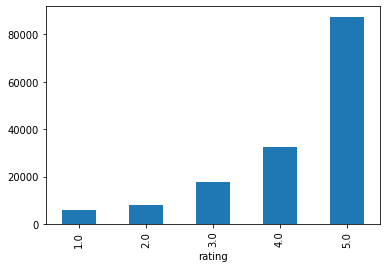

In [31]:
df.groupby('rating').size().plot(kind="bar");

In [32]:
df['rating'].describe()

count    151254.000000
mean          4.243042
std           1.090003
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

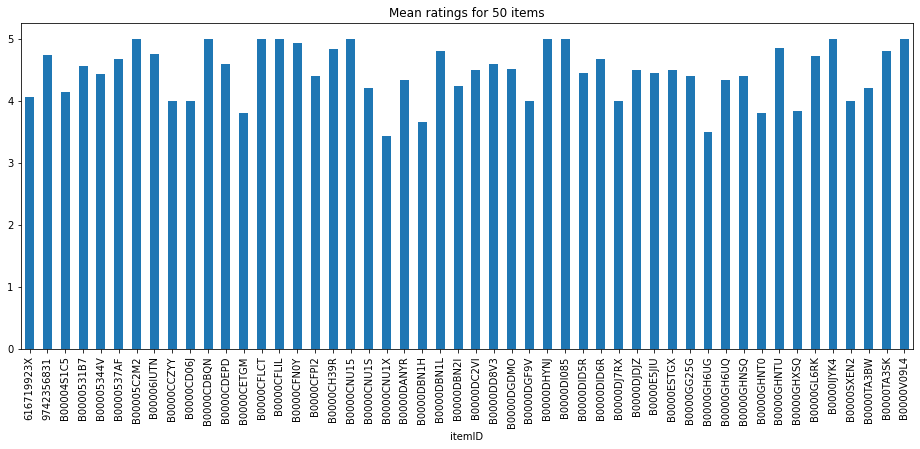

In [33]:
item_means=df.groupby('itemID').rating.mean()
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

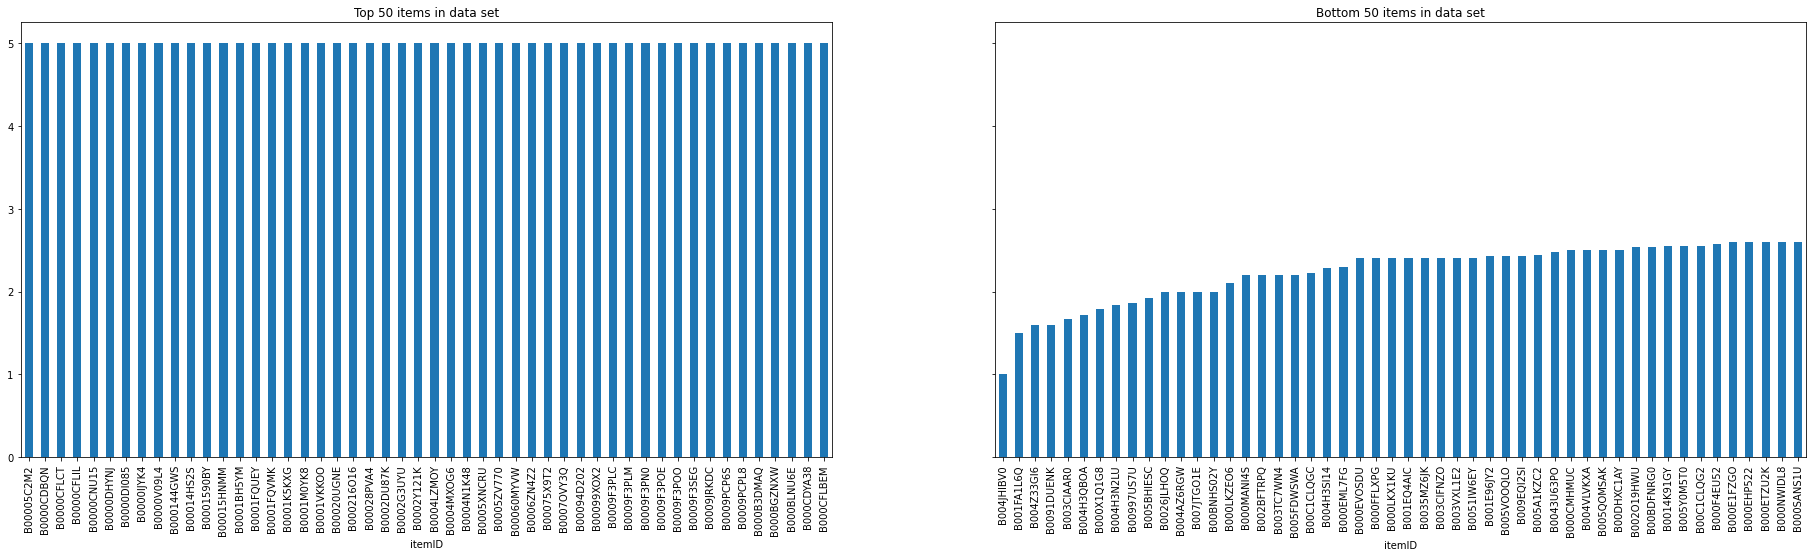

In [34]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,8), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

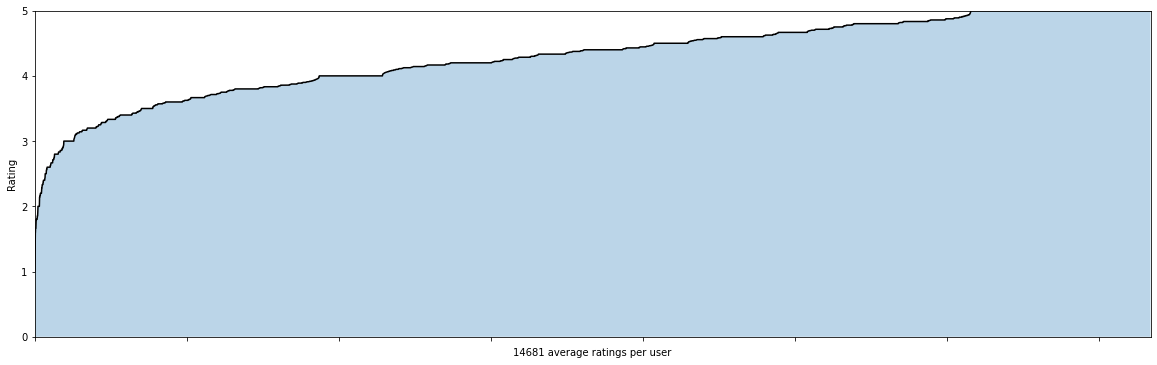

In [35]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.3)
ax.set_xticklabels("")
# 1000 labels is nonsensical
ax.set_ylabel("Rating")
ax.set_xlabel(f"{len(user_means)} average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means));

In [36]:
def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append("".join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append("".join(tmp))
    return " ".join(words)


class Baseline:
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError("baseline prediction not implemented for base class")

    def mse(self, test_data):
        """Calculate mean squared error for predictions on test data."""
        return mse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)


# Implement the 3 baselines.


class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i, j] = np.mean((global_mean, user_means[i]))
                else:
                    self.predicted[i, j] = np.mean((global_mean, user_means[i], item_means[j]))



In [37]:
baseline_methods = {}
baseline_methods["ur"] = UniformRandomBaseline
baseline_methods["gm"] = GlobalMeanBaseline
baseline_methods["mom"] = MeanOfMeansBaseline

In [38]:
num_users = df.userID.unique().shape[0]
num_items = df.itemID.unique().shape[0]
sparsity = 1 - len(df) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")


Users: 14681
Movies: 8713
Sparsity: 0.9988175480115385


In [39]:
dense_data = df.pivot(index="userID", columns="itemID", values="rating")

In [40]:
dense_data.shape

(14681, 8713)

In [41]:
dense_data.loc['A1VEELTKS8NLZB','616719923X']

4.0

In [42]:
theano.config.compute_test_value = "ignore"

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [43]:
ee=np.eye(3)
ee=ee*0.2
ee

array([[0.2, 0. , 0. ],
       [0. , 0.2, 0. ],
       [0. , 0. , 0.2]])

In [44]:
rr=np.random.randn(20, 5)*0.01
rr

array([[ 6.29112713e-03, -4.58777326e-03, -1.29721871e-02,
        -1.27163765e-02, -5.28735072e-03],
       [ 2.28479009e-03, -1.63045635e-02, -1.58644987e-03,
        -2.95014302e-03, -3.11569099e-03],
       [ 1.10418582e-02, -1.43020890e-02, -2.24529426e-03,
         1.31760728e-03, -2.89158991e-04],
       [ 9.79814855e-03,  1.12334558e-02,  2.43368160e-03,
        -3.30471442e-03, -4.26853468e-03],
       [-5.05584852e-03, -5.71540765e-03,  1.57977833e-03,
        -2.67447031e-03,  8.05157944e-03],
       [ 1.07402183e-02, -1.19253946e-02, -2.86609665e-04,
         7.06130416e-03, -8.21687668e-03],
       [ 3.51286815e-03,  1.97599145e-03,  2.32881625e-03,
         5.16230182e-03, -2.14655362e-02],
       [-1.39730617e-02, -6.41393928e-03, -7.18494946e-03,
        -1.66400207e-02, -3.47349444e-03],
       [ 1.01508815e-02,  3.97465106e-03, -1.14016849e-02,
        -8.81627502e-03, -2.49487899e-03],
       [-1.40023168e-02, -8.90909449e-03, -1.79127981e-02,
         2.16656277e-02

In [45]:
class PMF:

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1, 5)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()
        
        # Specify the model.
        logging.info("building the PMF model")
        with pm.Model() as pmf:
            U = pm.MvNormal(
                "U",
                mu=0,
                tau=self.alpha_u * np.eye(dim),
                shape=(n, dim),
                testval=np.random.randn(n, dim) * std,
            )
            print(U)
            V = pm.MvNormal(
                "V",
                mu=0,
                tau=self.alpha_v * np.eye(dim),
                shape=(m, dim),
                testval=np.random.randn(m, dim) * std,
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name
    

In [46]:
def _find_map(self):
  """Find mode of posterior using L-BFGS-B optimization."""
  tstart = time.time()
  with self.model:
    logging.info("finding PMF MAP using L-BFGS-B optimization...")
    self._map = pm.find_MAP(method="L-BFGS-B")

  elapsed = int(time.time() - tstart)
  logging.info("found PMF MAP in %d seconds" % elapsed)
  return self._map


def _map(self):
    try:
        return self._map
    except:
        return self.find_map()


In [47]:
# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.map = property(_map)

In [48]:
# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    kwargs.setdefault("chains", 1)
    with self.model:
        self.trace = pm.sample(**kwargs)


In [49]:
# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

In [50]:
def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


In [51]:
PMF.predict = _predict

In [52]:
def mse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return mse  # MSE

In [53]:


def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape  # # users, # movies
    N = n * m  # # cells in matrix
 
    # Prepare train/test ndarrays.
    train = data.to_numpy()
   
    test = np.ones(data.shape) * np.nan
  
  
    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))  # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))  # tuples of row/col index pairs
    print(idx_pairs)
    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size  # and remainder for training

    indices = np.arange(len(idx_pairs))  # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)
 
    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan  # remove from train set

    # Verify everything worked properly
    assert train_size == N - np.isnan(train).sum()
    assert test_size == N - np.isnan(test).sum()

    # Return train set and test set
    return train, test


  

In [60]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

0

In [55]:
train, test = split_train_test(dense_data)

[(0, 4550), (0, 5257), (0, 5697), (0, 6045), (0, 7653), (0, 7654), (0, 7655), (0, 7710), (0, 7804), (0, 7889), (0, 7943), (0, 8005), (0, 8311), (1, 963), (1, 2920), (1, 5574), (1, 5599), (1, 5606), (1, 5607), (1, 5612), (1, 5691), (1, 8460), (1, 8510), (2, 432), (2, 864), (2, 1389), (2, 5615), (2, 5910), (3, 1638), (3, 1784), (3, 3722), (3, 6047), (3, 7653), (3, 7750), (3, 8005), (3, 8473), (3, 8474), (4, 474), (4, 518), (4, 1467), (4, 1516), (4, 2270), (4, 2825), (4, 2826), (4, 2829), (4, 5249), (5, 3118), (5, 4094), (5, 4925), (5, 5354), (5, 5668), (5, 6466), (6, 1211), (6, 1467), (6, 2522), (6, 2704), (6, 2705), (6, 4407), (6, 5102), (6, 5626), (6, 6945), (7, 1785), (7, 2620), (7, 3916), (7, 4000), (7, 5435), (7, 7218), (7, 8407), (8, 165), (8, 166), (8, 1319), (8, 1330), (8, 1788), (8, 2890), (8, 5200), (9, 593), (9, 3909), (9, 5950), (9, 6180), (9, 7750), (10, 103), (10, 897), (10, 2075), (10, 5327), (10, 6396), (10, 7481), (10, 7869), (10, 8022), (10, 8034), (11, 93), (11, 240), 

In [ ]:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.mse(test)
    print("{} MSE:\t{:.5f}".format(method, baselines[name]))

Uniform Random Baseline MSE:	4.01167
Global Mean Baseline MSE:	1.19862
Mean Of Means Baseline MSE:	1.02492


In [56]:
pmf = PMF(train,dim=10, alpha=2, std=0.05)

INFO:root:building the PMF model
INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:Compiling new CVM
INFO:/usr/local/lib/python3.7/dist-packages/theano/link/c/lazylinker_c.py:New version 0.211


U ~ MvNormal


INFO:root:done building the PMF model


In [57]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

0

In [58]:

pmf.find_map()


INFO:root:finding PMF MAP using L-BFGS-B optimization...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


INFO:root:found PMF MAP in 75 seconds


{'U': array([[-1.68674887e-06,  6.30364764e-07, -4.73856963e-06, ...,
          5.48593744e-06, -3.14892125e-06,  5.53741085e-06],
        [ 2.31257189e-07,  5.86082757e-08, -2.15128283e-07, ...,
         -9.19088354e-07, -3.55622201e-07, -6.73747865e-07],
        [-1.21866274e-06, -6.84818054e-07, -3.23013347e-07, ...,
          1.02841487e-07,  6.18256120e-07,  3.72822555e-07],
        ...,
        [ 2.34921610e-07,  5.72749313e-07, -1.16889093e-06, ...,
          1.42411472e-07, -1.79607941e-06,  1.36045387e-06],
        [-2.05261534e-07, -1.74911924e-07,  2.79130485e-07, ...,
          1.08537077e-07, -5.60666530e-07, -1.08541131e-07],
        [-3.84955073e-07, -2.99686638e-06, -9.84425893e-07, ...,
         -2.45570194e-07, -1.75179917e-06,  2.59996263e-06]]),
 'V': array([[ 4.72587182e-07, -1.27900850e-07,  7.07520935e-08, ...,
          1.16740752e-07, -3.32364185e-07, -6.82777662e-07],
        [ 4.96265434e-07, -3.30054260e-07,  1.22305321e-06, ...,
          3.52563461e-08, -1

In [ ]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_mse = mse(train, predictions)
    test_mse = mse(test, predictions)
    overfit = test_mse - train_mse

    # Print report.
    print("PMF MAP training MSE: %.5f" % train_mse)
    print("PMF MAP testing MSE:  %.5f" % test_mse)
    print("Train/test difference: %.5f" % overfit)

    return test_mse


In [ ]:
PMF.eval_map = eval_map

In [ ]:
pmf_map_mse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_mse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)

PMF MAP training MSE: 11.56580
PMF MAP testing MSE:  11.46292
Train/test difference: -0.10289
PMF MAP Improvement:   -10.43799


In [59]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

0

In [ ]:
# Draw MCMC samples.
pmf.draw_samples(
    draws=20,
    tune=20,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Only 5 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
INFO:pymc3:Sequential sampling (1 chains in 1 job)
NUTS: [V, U]
INFO:pymc3:NUTS: [V, U]


Sampling 1 chain for 5 tune and 5 draw iterations (5 + 5 draws total) took 62 seconds.
INFO:pymc3:Sampling 1 chain for 5 tune and 5 draw iterations (5 + 5 draws total) took 62 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
def _norms(pmf_model, monitor=("U", "V"), ord="fro"):
    """Return norms of latent variables at each step in the
    sample trace. These can be used to monitor convergence
    of the sampler.
    """
    monitor = ("U", "V")
    norms = {var: [] for var in monitor}
    for sample in pmf_model.trace:
        for var in monitor:
            norms[var].append(np.linalg.norm(sample[var], ord))
    return norms


def _traceplot(pmf_model):
    """Plot Frobenius norms of U and V as a function of sample #."""
    trace_norms = pmf_model.norms()
    u_series = pd.Series(trace_norms["U"])
    v_series = pd.Series(trace_norms["V"])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    u_series.plot(kind="line", ax=ax1, grid=False, title=r"$\|U\|_{Fro}^2$ at Each Sample")
    v_series.plot(kind="line", ax=ax2, grid=False, title=r"$\|V\|_{Fro}^2$ at Each Sample")
    ax1.set_xlabel("Sample Number")
    ax2.set_xlabel("Sample Number")


In [ ]:
PMF.norms = _norms
PMF.traceplot = _traceplot

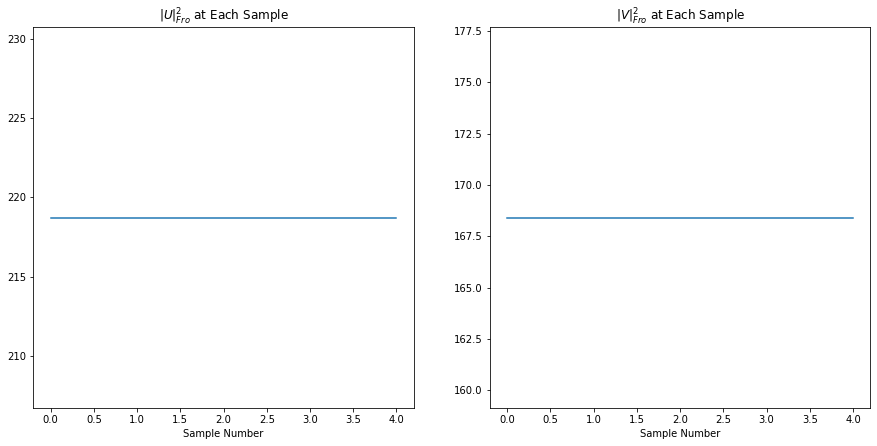

In [ ]:
pmf.traceplot()

In [ ]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

0

In [ ]:
def _running_mse(pmf_model, test_data, train_data, burn_in=0, plot=True):
    """Calculate MSE for each step of the trace to monitor convergence."""
    burn_in = burn_in if len(pmf_model.trace) >= burn_in else 0
    results = {"per-step-train": [], "running-train": [], "per-step-test": [], "running-test": []}
    R = np.zeros(test_data.shape)
    running_R=0
    for cnt, sample in enumerate(pmf_model.trace[burn_in:]):
        sample_R = pmf_model.predict(sample["U"], sample["V"])
        R += sample_R
        running_R = R / (cnt + 1)
        results["per-step-train"].append(mse(train_data, sample_R))
        results["running-train"].append(mse(train_data, running_R))
        results["per-step-test"].append(mse(test_data, sample_R))
        results["running-test"].append(mse(test_data, running_R))

    results = pd.DataFrame(results)

    if plot:
        results.plot(
            kind="line",
            grid=False,
            figsize=(15, 7),
            title="Per-step and Running MSE From Posterior Predictive",
        )

    # Return the final predictions, and the RMSE calculations
    return running_R, results


In [ ]:
PMF.running_mse = _running_mse


In [ ]:
predicted, results = pmf.running_mse(test, train)

In [ ]:
# And our final RMSE?
final_test_mse = results["running-test"].values[-1]
final_train_mse = results["running-train"].values[-1]
print("Posterior predictive train MSE: %.5f" % final_train_mse)
print("Posterior predictive test MSE:  %.5f" % final_test_mse)
print("Train/test difference:           %.5f" % (final_test_mse - final_train_mse))
print("Improvement from MAP:            %.5f" % (pmf_map_mse - final_test_mse))
print("Improvement from Mean of Means:  %.5f" % (baselines["mom"] - final_test_mse))

In [ ]:
size = 100  # RMSE doesn't really change after 100th sample anyway.
all_results = pd.DataFrame(
    {
        "uniform random": np.repeat(baselines["ur"], size),
        "global means": np.repeat(baselines["gm"], size),
        "mean of means": np.repeat(baselines["mom"], size),
        "PMF MAP": np.repeat(pmf_map_mse, size),
        "PMF MCMC": results["running-test"][:size],
    }
)
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind="line", grid=False, ax=ax, title="MSE for all methods")
ax.set_xlabel("Number of Samples")
ax.set_ylabel("MSE");

NameError: ignored